# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


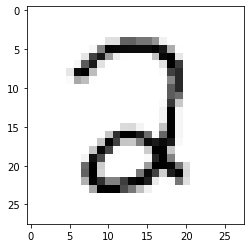

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2361
Training Accuracy: 0.7330, Testing Accuracy: 0.7515



Epoch 10, Loss 0.0641
Training Accuracy: 0.9391, Testing Accuracy: 0.9516



Epoch 20, Loss 0.0434
Training Accuracy: 0.9563, Testing Accuracy: 0.9602



Epoch 30, Loss 0.0359
Training Accuracy: 0.9623, Testing Accuracy: 0.9677



Epoch 40, Loss 0.0319
Training Accuracy: 0.9656, Testing Accuracy: 0.9718



Epoch 50, Loss 0.0292
Training Accuracy: 0.9671, Testing Accuracy: 0.9743



Epoch 60, Loss 0.0273
Training Accuracy: 0.9693, Testing Accuracy: 0.9743



Epoch 70, Loss 0.0258
Training Accuracy: 0.9708, Testing Accuracy: 0.9758



Epoch 80, Loss 0.0245
Training Accuracy: 0.9725, Testing Accuracy: 0.9748



Epoch 90, Loss 0.0235
Training Accuracy: 0.9732, Testing Accuracy: 0.9758



Epoch 100, Loss 0.0226
Training Accuracy: 0.9745, Testing Accuracy: 0.9753



Epoch 110, Loss 0.0218
Training Accuracy: 0.9754, Testing Accuracy: 0.9758



Epoch 120, Loss 0.021
Training Accuracy: 0.9757, Testing Accuracy: 0.9763



Epoch 130, Loss 0.0204
Training Accuracy: 0.9765, Testing Accuracy: 0.9763



Epoch 140, Loss 0.0198
Training Accuracy: 0.9773, Testing Accuracy: 0.9758



Epoch 150, Loss 0.0192
Training Accuracy: 0.9783, Testing Accuracy: 0.9758



Epoch 160, Loss 0.0187
Training Accuracy: 0.9786, Testing Accuracy: 0.9763



Epoch 170, Loss 0.0181
Training Accuracy: 0.9795, Testing Accuracy: 0.9768



Epoch 180, Loss 0.0176
Training Accuracy: 0.9799, Testing Accuracy: 0.9778



Epoch 190, Loss 0.0172
Training Accuracy: 0.9808, Testing Accuracy: 0.9783



Epoch 200, Loss 0.0167
Training Accuracy: 0.9814, Testing Accuracy: 0.9788



Epoch 210, Loss 0.0163
Training Accuracy: 0.9817, Testing Accuracy: 0.9798



Epoch 220, Loss 0.0159
Training Accuracy: 0.9827, Testing Accuracy: 0.9793



Epoch 230, Loss 0.0155
Training Accuracy: 0.9832, Testing Accuracy: 0.9798



Epoch 240, Loss 0.0151
Training Accuracy: 0.9836, Testing Accuracy: 0.9798



0.0031387923127579064

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2198
Training Accuracy: 0.7128, Testing Accuracy: 0.6880



Epoch 10, Loss 0.1019
Training Accuracy: 0.9130, Testing Accuracy: 0.9204



Epoch 20, Loss 0.078
Training Accuracy: 0.9321, Testing Accuracy: 0.9415



Epoch 30, Loss 0.0672
Training Accuracy: 0.9403, Testing Accuracy: 0.9506



Epoch 40, Loss 0.0608
Training Accuracy: 0.9458, Testing Accuracy: 0.9546



Epoch 50, Loss 0.0564
Training Accuracy: 0.9474, Testing Accuracy: 0.9556



Epoch 60, Loss 0.0533
Training Accuracy: 0.9494, Testing Accuracy: 0.9551



Epoch 70, Loss 0.0508
Training Accuracy: 0.9506, Testing Accuracy: 0.9556



Epoch 80, Loss 0.0488
Training Accuracy: 0.9517, Testing Accuracy: 0.9561



Epoch 90, Loss 0.0472
Training Accuracy: 0.9529, Testing Accuracy: 0.9592



Epoch 100, Loss 0.0458
Training Accuracy: 0.9541, Testing Accuracy: 0.9592



Epoch 110, Loss 0.0447
Training Accuracy: 0.9549, Testing Accuracy: 0.9607



Epoch 120, Loss 0.0436
Training Accuracy: 0.9559, Testing Accuracy: 0.9612



Epoch 130, Loss 0.0427
Training Accuracy: 0.9564, Testing Accuracy: 0.9622



Epoch 140, Loss 0.0419
Training Accuracy: 0.9569, Testing Accuracy: 0.9632



Epoch 150, Loss 0.0412
Training Accuracy: 0.9575, Testing Accuracy: 0.9637



Epoch 160, Loss 0.0406
Training Accuracy: 0.9580, Testing Accuracy: 0.9637



Epoch 170, Loss 0.04
Training Accuracy: 0.9587, Testing Accuracy: 0.9642



Epoch 180, Loss 0.0394
Training Accuracy: 0.9591, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0389
Training Accuracy: 0.9595, Testing Accuracy: 0.9657



Epoch 200, Loss 0.0384
Training Accuracy: 0.9598, Testing Accuracy: 0.9662



Epoch 210, Loss 0.038
Training Accuracy: 0.9600, Testing Accuracy: 0.9667



Epoch 220, Loss 0.0376
Training Accuracy: 0.9601, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0372
Training Accuracy: 0.9605, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0369
Training Accuracy: 0.9606, Testing Accuracy: 0.9672



0.02774751321442607

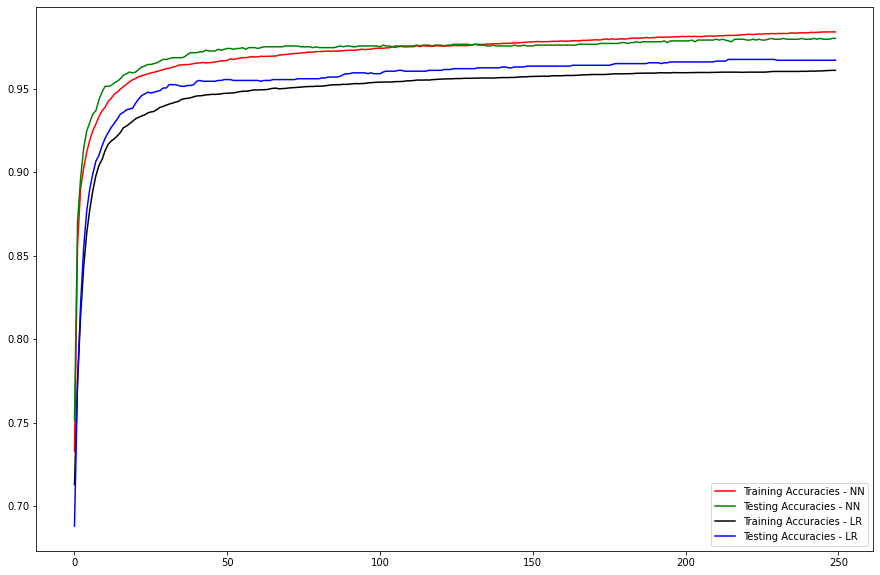

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

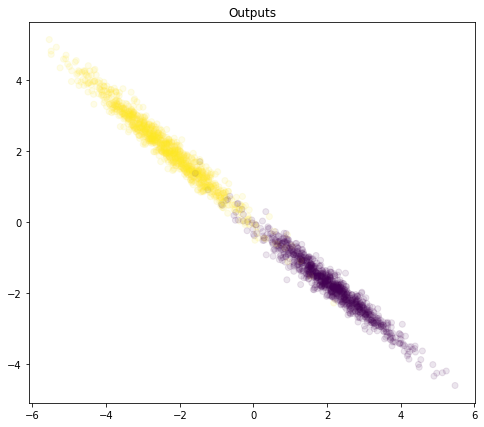

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

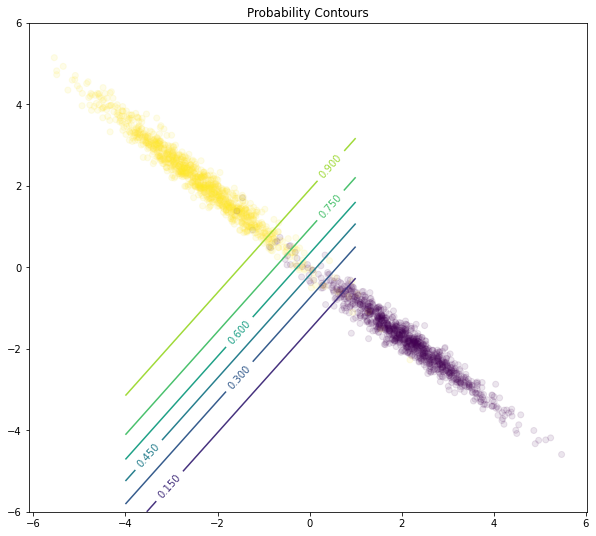

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );